In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

In [2]:
# load the images array
loaded_data = np.load("drive/MyDrive/Colab Notebooks/images_np.npz")
images = np.array([loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))])
images = np.squeeze(images, axis=0)

In [3]:
# load the boxes array
loaded_data = np.load("drive/MyDrive/Colab Notebooks/boxes_np.npz")
bounding_boxes = np.array([loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))])
bounding_boxes = np.squeeze(bounding_boxes, axis=0)

In [4]:
images_train, images_test, boxes_train, boxes_test = train_test_split(
    images, bounding_boxes, test_size=0.05, random_state=42)

In [5]:
images_train, images_val, boxes_train, boxes_val = train_test_split(
    images_train, boxes_train, test_size=0.2, random_state=42)

In [6]:
def load_data(images, labels):
    for image, label in zip(images, labels):
        yield image, label

In [7]:
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_generator(
    lambda: load_data(images_train, boxes_train),
    output_types=(images_train.dtype, boxes_train.dtype),
    output_shapes=([300, 300,1], [4])
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: load_data(images_val, boxes_val),
    output_types=(images_val.dtype, boxes_val.dtype),
    output_shapes=([300, 300,1], [4])
)

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False


# create the cnn model
model = tf.keras.Sequential([
    # Input layer for grayscale images
    layers.Input(shape=(300, 300, 1)),
    # Lambda layer to replicate the grayscale channel to simulate RGB
    layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3])),
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    # Output layer for bounding box (x, y, width, height)
    layers.Dense(4)
])

In [4]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [10]:
history = model.fit(
    train_dataset,  # Training data and labels
    epochs=10,  # Number of epochs to train for
    validation_data=validation_dataset  # Validation data and labels
)

Epoch 1/10
20/20 [==============================] - 10s 124ms/step - loss: 0.3283 - mae: 0.4329 - val_loss: 0.2688 - val_mae: 0.4199
Epoch 2/10
20/20 [==============================] - 1s 24ms/step - loss: 0.1740 - mae: 0.3176 - val_loss: 0.2211 - val_mae: 0.3620
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.1125 - mae: 0.2511 - val_loss: 0.1836 - val_mae: 0.3060
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.0670 - mae: 0.1956 - val_loss: 0.1752 - val_mae: 0.2902
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.0437 - mae: 0.1557 - val_loss: 0.1543 - val_mae: 0.2657
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.0322 - mae: 0.1318 - val_loss: 0.1515 - val_mae: 0.2653
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.0271 - mae: 0.1234 - val_loss: 0.1954 - val_mae: 0.3073
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.0581 -

In [19]:
model.save("drive/MyDrive/Colab Notebooks/plate_recognizer_01.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# load a saved model
from tensorflow.keras.models import load_model

#model = load_model('trained_model/plate_recognizer_01.h5')
model.load_weights('trained_model/plate_recognizer_01.h5')

IndexError: list index out of range

In [11]:
print(tf.__version__)

2.15.0


1/1 [==============================] - 0s 24ms/step
[126.68145  66.44613 157.09877  75.33262]
[184.   56.  215.   64.5]


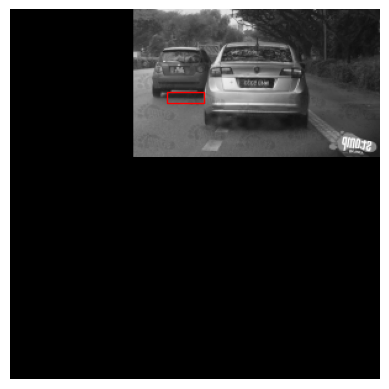

In [34]:
# test the trained model

test_index = 0

test_image = np.expand_dims(images_test[test_index], axis=0)
predicted_box = model.predict(test_image)

predicted_box = np.squeeze(predicted_box, axis=0)

predicted_box = predicted_box * 100
test_image = test_image * 100
#predicted_box[0] = predicted_box[0] / 200.0
#predicted_box[0][3] = predicted_box[0][3] * -1.0
real_box = boxes_test[test_index] * 100

print(predicted_box)
print(real_box)
#predicted_box = real_box
# print(images_test.shape)
# print(boxes_test.shape)
fig, ax = plt.subplots(1)

# Display the original image
plt.imshow(np.squeeze(test_image, axis=0).astype('float32'), cmap='gray')  # Assuming this is already normalized and ready for display

# Create a Rectangle patch for the predicted bounding box
rect = patches.Rectangle((predicted_box[0], predicted_box[1]), predicted_box[2]-predicted_box[0], predicted_box[3]-predicted_box[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.axis('off')  # Hide the axis
plt.show()


In [35]:
# come up with average mse for all the test images
total_mse = 0
for i, image in enumerate(images_test):
  test_image = np.expand_dims(image, axis=0)
  predicted_box = model.predict(test_image)[0]
  real_box = boxes_test[i]
  mse = tf.keras.losses.mean_squared_error(predicted_box, real_box)
  mean = tf.reduce_mean(mse)
  total_mse += mean


print(total_mse / len(images_test))

1/1 [==============================] - 0s 25ms/step
tf.Tensor(0.13533262248493794, shape=(), dtype=float64)


In [ ]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    box1, box2: list of four integers [xmin, ymin, xmax, ymax]
    Each bounding box should be in the format [xmin, ymin, xmax, ymax]
    
    Returns:
    float: the IoU of the two bounding boxes.
    """
    # Unpack the coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Determine the coordinates of the intersection rectangle
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)
    
    # Calculate the area of intersection
    inter_width = max(x_inter_max - x_inter_min, 0)
    inter_height = max(y_inter_max - y_inter_min, 0)
    inter_area = inter_width * inter_height
    
    # Calculate the area of both bounding boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Calculate the area of union
    union_area = box1_area + box2_area - inter_area
    
    # Calculate the IoU
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou



In [ ]:
# calculate recall and precision
TP = 0
FP = 0
FN = 0
detected = [False] * len(images_test)

iou_threshold = 0.5

for i, image in enumerate(images_test):
    test_image = np.expand_dims(image, axis=0)
    predicted_box = model.predict(test_image)[0]
    real_box = boxes_test[i]

    if calculate_iou(predicted_box, real_box) >= iou_threshold:
        TP += 1
    else:
        FP += 1

FN = len(images_test) - TP

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(precision)
print(recall)